In [1]:
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from monte_carlo import *
from black_scholes import *


# Monte Carlo Simulation

Monte Carlo simulation is useful for pricing options that don’t have a closed-form solution, such as path-dependent options (options that depend on the stock’s history over time). 

However, even for standard European options, it provides an intuitive way to estimate prices by simulating realistic price movements.

Formula for call options:

$$C = e^{-rT} \times \mathbb{E}[max(S_T -K,0)]$$

where
* $C$ - Option price today
* $\mathbb{E}[\dot\ ]$ - Expected value (average over all simulations)
* $e^{−rT}$ - Discount factor

Implementation:

1. Simulation of multiple stock price paths using Geometric Brownian Motion (GBM).

$$S_{t+1} = S_t \times e^{(r-0.5 \sigma^2)dt + \sigma \sqrt{dt}Z}$$

where $Z ~ N(0,1)$ is a random normal variable. 

2. Calculation of call and put payoffs at expiration 

3. Discount the expected payoff back to present value using the risk-free rate.


In [2]:
# Example usage
S = 1       
K = 1.10       
T = 1         
r = 0.06      
sigma = 0.2   
num_simulations = 1000000  
num_steps = 1           

prices_call = monte_carlo_european(S, K, T, r, sigma, num_simulations, num_steps, 'call')
prices_put = monte_carlo_european(S, K, T, r, sigma, num_simulations, num_steps, 'put')

# compare with the Black-Scholes formula
p_call = black_scholes_equation(S, K, T, r, sigma, 'c')
p_put = black_scholes_equation(S, K, T, r, sigma, 'p')

print(f"European Call Price: {prices_call:.4f}")
print(f"Black-Scholes Call Price: {p_call:.4f}")

print(f"European Put Price: {prices_put:.4f}")
print(f"Black-Scholes Put Price: {p_put:.4f}")

European Call Price: 0.0005
Black-Scholes Call Price: 0.0644
European Put Price: 0.4907
Black-Scholes Put Price: 0.1003


## American options

American options allow for early exercise of the option.
Therefore, when pricing the option, one needs to take into account each time period before he contract's end date. 

The first step is generate stock prices paths with monte carlo simulation of brownian motion: 

Simulated Stock Price Paths:
[[1.57889279 1.2394713  1.21527246 0.77179731 1.76775503 3.04278271
  1.92013752 1.76924666]
 [0.99337293 1.11270224 1.45520923 1.07507389 1.40488607 2.56273513
  1.56975447 1.86310142]
 [0.81817434 0.92821156 1.1798765  1.00900511 1.13090032 1.87866968
  1.60374928 1.42925764]
 [0.74596664 0.79362546 0.97185359 0.86245299 0.90019372 1.20027488
  1.26694916 1.14773843]
 [1.08040425 0.80443095 1.09263979 1.21377972 1.05939693 1.01850991
  1.03735264 1.09878656]
 [1.         1.         1.         1.         1.         1.
  1.         1.        ]]


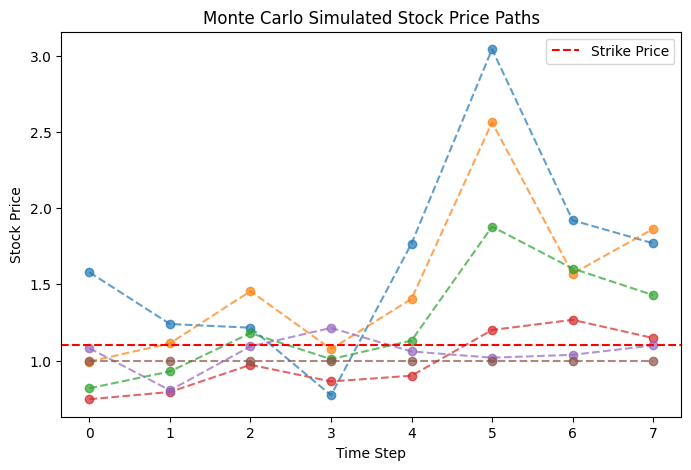

In [3]:
# Parameters
num_paths = 8
dt = 1
T = 5

stock_paths = simulate_stock_path(S, T, r, sigma, num_paths, dt)

# Display generated paths
print("Simulated Stock Price Paths:")
print(stock_paths)

# Plot paths
plot_stock_path(stock_paths, K)


then one computes the cash flows generated if the option was exercised at any point in time:

In [4]:
cash_flows, discount_cash_flow = cash_flow(stock_paths, K, 'call')
print("Cash Flow Matrix:")
print(cash_flows)

Cash Flow Matrix:
[[0.47889279 0.1394713  0.11527246 0.         0.66775503 1.94278271
  0.82013752 0.66924666]
 [0.         0.01270224 0.35520923 0.         0.30488607 1.46273513
  0.46975447 0.76310142]
 [0.         0.         0.0798765  0.         0.03090032 0.77866968
  0.50374928 0.32925764]
 [0.         0.         0.         0.         0.         0.10027488
  0.16694916 0.04773843]
 [0.         0.         0.         0.11377972 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


This algorithm maximizes the value of the option by creating a stopping rule. 

In other words, it will considers each time period and looks to understand if one should exercise the option or continue holding it for the next period.

There they compare the payoff at a specific point to the conditional expectation of holding the option. 

In [5]:
# Create index to only look at in-the-money paths at time t
in_the_money =stock_paths[1,:] < K

# Run Regression
X = (stock_paths[1,in_the_money])
X2 = X*X
Xs = np.column_stack([X,X2])
Y = cash_flows[1-1,in_the_money]  * np.exp(-r)

continuations = regression(Xs, Y, stock_paths, in_the_money)

print(continuations)

[0.45100425 0.         0.         0.         0.         0.
 0.         0.        ]


In [6]:
# If continuation is greater in t =0, then cash flow in t=1 is zero
cash_flows[1,:] = np.where(continuations> cash_flows[1,:], 0, cash_flows[1,:])
print(cash_flows)

[[0.47889279 0.1394713  0.11527246 0.         0.66775503 1.94278271
  0.82013752 0.66924666]
 [0.         0.01270224 0.35520923 0.         0.30488607 1.46273513
  0.46975447 0.76310142]
 [0.         0.         0.0798765  0.         0.03090032 0.77866968
  0.50374928 0.32925764]
 [0.         0.         0.         0.         0.         0.10027488
  0.16694916 0.04773843]
 [0.         0.         0.         0.11377972 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


In [7]:
# If stopped ahead of time, subsequent cashflows = 0
exercised_early = continuations < cash_flows[1, :]
cash_flows[0:1, :][:, exercised_early] = 0
discount_cash_flow[0,:] = cash_flows[0,:]* np.exp(-r * 3)
print(cash_flows)

[[0.47889279 0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.01270224 0.35520923 0.         0.30488607 1.46273513
  0.46975447 0.76310142]
 [0.         0.         0.0798765  0.         0.03090032 0.77866968
  0.50374928 0.32925764]
 [0.         0.         0.         0.         0.         0.10027488
  0.16694916 0.04773843]
 [0.         0.         0.         0.11377972 0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]


All together:

In [10]:
S = 1
K=1.1
r=0.06
sigma = 0.2
num_paths = 1000
dt = 1/3
T = 1

price_a_put = monte_carlo_lsm_american(S, K, r, sigma, num_paths, dt, 'put', T)
price_a_call = monte_carlo_lsm_american(S, K, r, sigma, num_paths, dt, 'call', T)

print(f"American Put Price: {price_a_put:.4f}")
print(f"American Call Price: {price_a_call:.4f}")

American Put Price: 0.1883
American Call Price: 0.0318
